In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

Read Train file for Train the model to predict the fare of ticket

In [2]:
train_data = pd.read_csv("train.csv")

using .head() we see the about 5 rows with the column name by which we can check what values and columns are there

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Using Info we can see non-null value and dtype of the column


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Below we find the % of survived in both male and female and have a bar chart to show that how many are survived

In [5]:
try:
    men = train_data.loc[train_data.Sex == 'male']['Survived']
    alive_men = men.mean()
    print("% of male who survived", alive_men);
except ZeroDivisionError:
    print("Error: No male passengers found (division by zero).")

% of male who survived 0.18890814558058924


In [6]:
try:
    women = train_data.loc[train_data.Sex == 'female']['Survived']
    alive_women = women.mean()
    print("% of male who survived", alive_women);
except ZeroDivisionError:
    print("Error: No female passengers found (division by zero).")

% of male who survived 0.7420382165605095


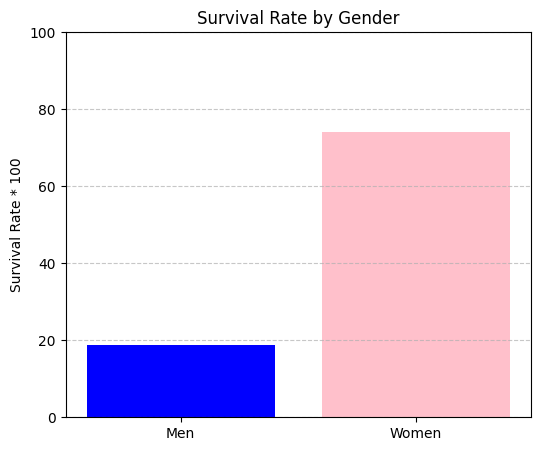

In [7]:
#showing 
plt.figure(figsize=(6, 5))
plt.bar(['Men', 'Women'], [alive_men*100, alive_women*100], color=['blue', 'pink'])
plt.ylabel('Survival Rate * 100')
plt.title('Survival Rate by Gender')
plt.ylim(0, 100)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Below I use feature engineering
by which we can the family size.

male -> 0 and female -> 1


In [8]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
train_data = pd.get_dummies(train_data, columns=['Embarked'])


In Y_train we train the fare data
and in X_train we train features data
where, there is input missing we use fillna and 
we put a mean of features value

In [168]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
X_train = train_data[features].fillna(train_data[features].mean())  # Impute missing
Y_train = train_data['Fare']

In [169]:
train_data_clean = train_data.dropna(subset=features + ['Fare'])
X_train = train_data_clean[features].values
Y_train = train_data_clean['Fare'].values


We compute the cost using vectorization

In [170]:
def compute_cost_vec(X, y, w, b):
    m = X.shape[0]
    f_wb = X.dot(w) + b                      # shape (m,)
    cost = np.sum((f_wb - y)**2) / (2 * m)
    return cost


Here we compute the gradient using vector using vectorization

In [171]:
def compute_gradient_vec(X, y, w, b):
    m, n = X.shape
    f_wb = X.dot(w) + b        
    err = f_wb - y             

    dj_dw = (1/m) * X.T.dot(err)  
    dj_db = (1/m) * np.sum(err)   
    return dj_db, dj_dw


In [172]:

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn parameters w and b.
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated parameters 
      b (scalar)       : Updated parameter 
      J_history (list) : History of cost function values
    """
    
    J_history = []
    w = w_in.copy()  # avoid modifying original array outside this function
    b = b_in

    for i in range(num_iters):
        # Compute gradient
        dj_db, dj_dw = compute_gradient_vec(X, y, w, b)

        # Update parameters
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost for plotting or analysis
        if i < 100000:
            cost = cost_function(X, y, w, b)
            J_history.append(cost)

        # Print cost every 10% of iterations
        if i % max(1, math.ceil(num_iters / 10)) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.4f}")

    return w, b, J_history


In [173]:
# initialize parameters
w_init = 0
initial_w = np.zeros_like(w_init)
initial_b = 0.
# some gradient descent settings
iterations = 500
alpha = 5.0e-7
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_train, Y_train, initial_w, initial_b,
                                                    compute_cost_vec, compute_gradient_vec, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    print(f"prediction: {np.dot(X_train[i], w_final) + b_final:0.2f}, target value: {y_train[i]}")

ValueError: operands could not be broadcast together with shapes (714,9) (714,) 

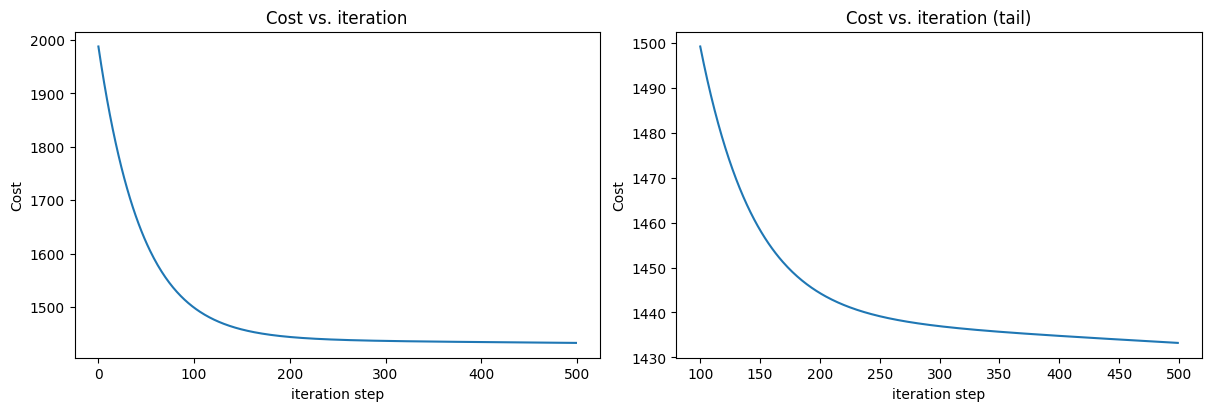

In [147]:
# plot cost versus iteration  
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [148]:
def zscore_normalize_features(X):

    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 


In [154]:
# Feature engineering
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'FamilySize']

# Impute missing values with column mean
train_data[features] = train_data[features].fillna(train_data[features].mean())

X_train = train_data[features].values
Y_train = train_data['Fare'].values

# Normalize
X_norm, mu, sigma = zscore_normalize_features(X_train)


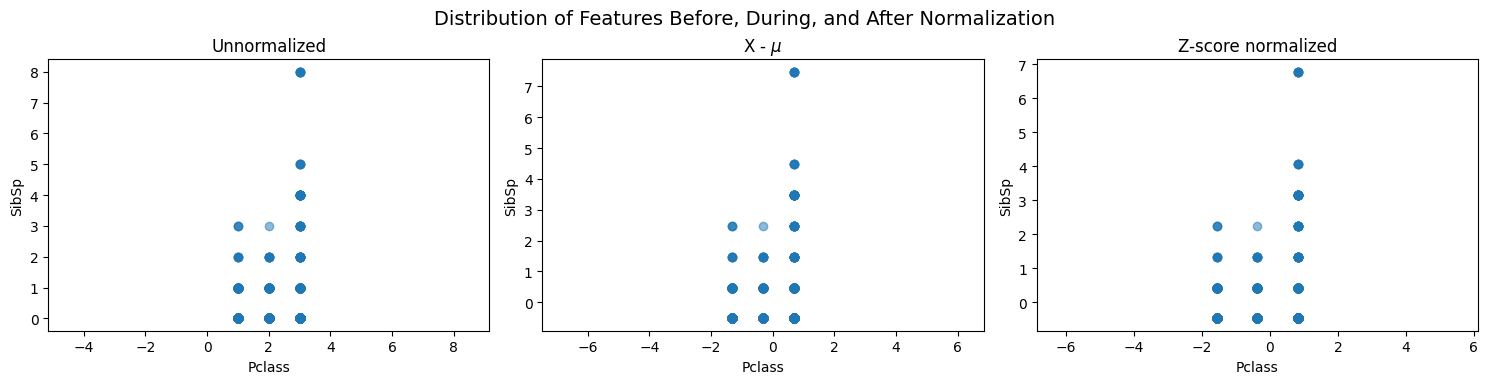

In [155]:
# Assuming X_train and features are already defined
mu     = np.mean(X_train, axis=0)   
sigma  = np.std(X_train, axis=0) 
X_mean = X_train - mu
X_norm = (X_train - mu) / sigma

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# 0: Raw
ax[0].scatter(X_train[:, 0], X_train[:, 3], alpha=0.5)
ax[0].set_xlabel(features[0])
ax[0].set_ylabel(features[3])
ax[0].set_title("Unnormalized")
ax[0].axis('equal')

# 1: Mean-centered
ax[1].scatter(X_mean[:, 0], X_mean[:, 3], alpha=0.5)
ax[1].set_xlabel(features[0])
ax[1].set_ylabel(features[3])
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

# 2: Z-score normalized
ax[2].scatter(X_norm[:, 0], X_norm[:, 3], alpha=0.5)
ax[2].set_xlabel(features[0])
ax[2].set_ylabel(features[3])
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')

# Add spacing and main title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Distribution of Features Before, During, and After Normalization", fontsize=14)
plt.show()